# Diffusion Equation
$$\frac{\partial y}{\partial t} = \frac{\partial^2 y}{\partial x^2} - e^{-t} (\sin(\pi x) - \pi^2 \sin (\pi x))$$
with $x\in [-1,1], t\in[0,1]$, $y(x,0)=\sin(\pi x)$, $y(-1,t)=y(1,t)=0$.

Solution: $y=e^{-t}\sin(\pi x)$

## DeepMacroFin

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import Comparator, EndogVar, EndogVarConditions, EndogEquation, OptimizerType, set_seeds

set_seeds(0)
pde1 = PDEModel("diffusion_1d", {"optimizer_type": OptimizerType.Adam})
pde1.set_state(["x", "t"], {"x": [-1., 1.], "t": [0, 1.]})
pde1.add_endog("y")
pde1.add_endog_equation("y_t = y_xx - exp(-t) * (sin(pi * x) - pi**2 * sin(pi*x))", label="base_pde")

mone_xs = -1 * torch.ones((100, 2))
mone_xs[:, 1] = torch.Tensor(np.linspace(0, 1, 100))

one_xs = torch.ones((100, 2))
one_xs[:, 1] = torch.Tensor(np.linspace(0, 1, 100))

zero_ts = torch.zeros((100, 2))
zero_ts[:, 0] = torch.Tensor(np.linspace(-1, 1, 100))
y_zero_ts = torch.sin(torch.pi * zero_ts[:, 0:1])

pde1.add_endog_condition("y", 
                              "y(SV)", {"SV": mone_xs},
                              Comparator.EQ,
                              "0", {},
                              label="bc_zerox")
pde1.add_endog_condition("y", 
                              "y(SV)", {"SV": one_xs},
                              Comparator.EQ,
                              "0", {},
                              label="bc_onex")
pde1.add_endog_condition("y", 
                              "y(SV)", {"SV": zero_ts},
                              Comparator.EQ,
                              "y_zero_ts", {"y_zero_ts": y_zero_ts},
                              label="ic")

print(pde1)
if not os.path.exists("./models/diffusion_1d/diffusion_1d.pt"):
    pde1.train_model("./models/diffusion_1d", "diffusion_1d.pt", True)
    pde1.eval_model(True)
else:
    pde1.load_model(torch.load("./models/diffusion_1d/diffusion_1d.pt"))
    pde1.eval_model(True)

=========================Summary of Model diffusion_1d==========================
Config: {
 "batch_size": 100,
 "num_epochs": 1000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{}

================================State Variables=================================
x: [-1.0, 1.0]
t: [0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: y
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (linear_3): Linear(in_features=30, out_feat

Total loss: 0.0109: 100%|██████████| 1000/1000 [00:11<00:00, 86.69it/s]

training finished, total time :: 11.54310941696167
Best model saved to ./models/diffusion_1d/diffusion_1d_best.pt if valid
Model saved to ./models/diffusion_1d/diffusion_1d.pt
===================================Evaluating===================================
loss :: endogeq_base_pde: 0.0036,
endogvar_y_cond_bc_zerox: 0.0015,
endogvar_y_cond_bc_onex: 0.0016,
endogvar_y_cond_ic: 0.0011,
total_loss: 0.0078


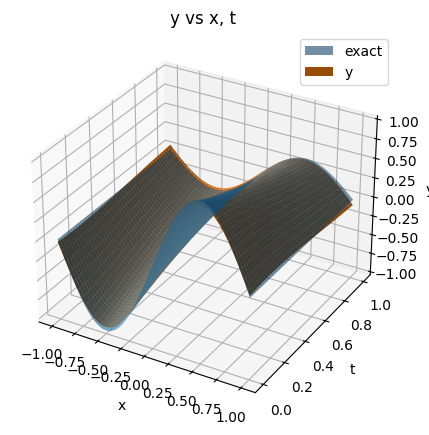

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
x_np = np.linspace(-1, 1, 100)
t_np = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_np, t_np)
exact_Y = np.exp(-T) * np.sin(np.pi*X)
ax.plot_surface(X, T, exact_Y, label="exact", alpha=0.6)
pde1.endog_vars["y"].plot("y", {"x": [-1., 1.], "t": [0, 1.]}, ax=ax)
plt.subplots_adjust()
plt.show()

## DeepXDE

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.000220 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.00e+01, 4.75e-02, 6.61e-01]    [1.78e+01, 4.75e-02, 6.61e-01]    [1.24e+00]    
1000      [2.46e-03, 1.65e-03, 5.38e-04]    [4.49e-03, 1.65e-03, 5.38e-04]    [5.11e-02]    

Best model at step 1000:
  train loss: 4.64e-03
  test loss: 6.68e-03
  test metric: [5.11e-02]

'train' took 9.496028 s



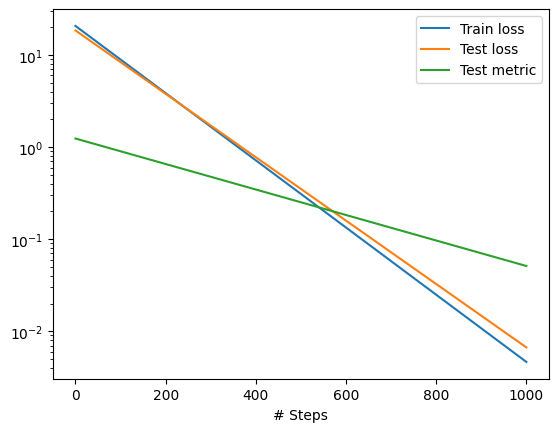

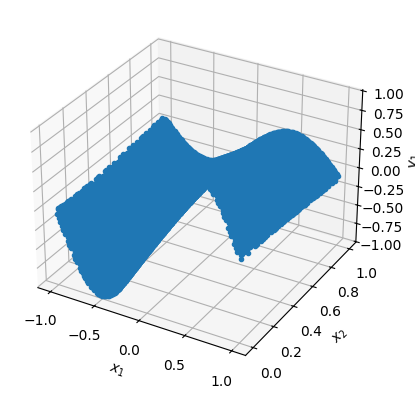

In [3]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Backend pytorch
# import torch
# Backend jax
# import jax.numpy as jnp
# Backend paddle
# import paddle


def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    # Backend pytorch
    return (
        dy_t
        - dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=100,
    num_boundary=100,
    num_initial=100,
    solution=func,
    num_test=10000,
)

layer_size = [2] + [30] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=1000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)